# Exercise: Managing and Exploiting Constraints

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise demonstrates design of prior covariance structure to achieve specific investigation objectives.  We first import basic libraries and configure our forward and inverse models.

In [1]:
import sys
import numpy as np
from scipy.linalg import norm
sys.path.insert(0,'isofit/')
import isofit
from figure_style import *
from os.path import join
from isofit.core.forward import ForwardModel
from isofit.core.geometry import Geometry
from isofit.inversion.inverse import Inversion
from scipy.interpolate import interp1d
from isofit.configs.configs import Config


instrument_settings = {"wavelength_file": join("data","wavelengths.txt"),
                       "integrations": 294,
                       "parametric_noise_file": join("data","avirisng_noise.txt"),
                       "unknowns": {
                             "cal_uncertainty_systematic_file": 
                             join("..","data","avirisng_systematic_error.txt"),
                             "uncorrelated_radiometric_uncertainty": 0.02}}

rtm_settings = {"statevector": {
                  "H2OSTR": 
                    {"bounds": [1.5, 2.0], 
                     "scale": 0.01, 
                     "init": 1.75, 
                     "prior_mean": 1.75, 
                     "prior_sigma": 2.0},
                  "AOT550": 
                    {"bounds": [0.01, 0.1], 
                     "scale": 0.01, 
                     "init": 0.05, 
                     "prior_mean": 0.05, 
                     "prior_sigma": 0.1}},
                "lut_grid": {"H2OSTR": [1.5, 2.0], 
                            "AOT550": [0.01, 0.1]},
                "unknowns": {"H2O_ABSCO": 0.01},
                "auto_rebuild":False,
                "radiative_transfer_engines":{
                    "vswir": {
                      "engine_name": "modtran",
                      "lut_path": join("data","lut"),
                      "wavelength_range": [350,2520],
                      "template_file": join("data","modtran.json"),
                      "lut_names": ["H2OSTR", "AOT550"],
                      "statevector_names": ["H2OSTR", "AOT550"]}}}

surface_settings = {"surface_category": "multicomponent_surface",
                    "surface_file": join("data","surface.mat"),
                    "select_on_init":True}

geom = Geometry()

fm_config = Config({ "forward_model":{"instrument":instrument_settings,
                   "surface":surface_settings,
                   "radiative_transfer": rtm_settings}})
fm = ForwardModel(fm_config)

inversion_settings = {"implementation": {
 "mode": "inversion",
 "inversion": {
  "windows": [[380.0, 1300.0], [1450, 1780.0], [1950.0, 2450.0]]}}}
    
inverse_config = Config(inversion_settings)
iv = Inversion(inverse_config, fm)

We begin by loading the data cube that we saw in the previous exercise.  Let's run the inversion on a single spectrum and take a look at the output.

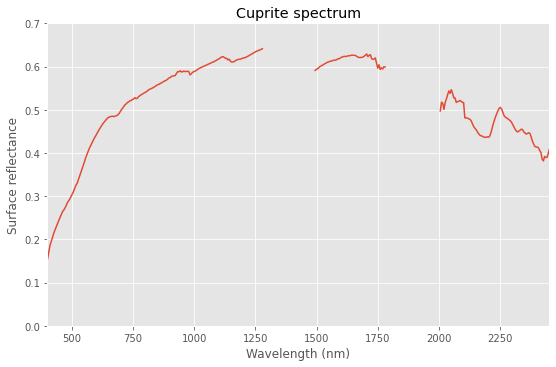

In [2]:
filename = join('..','13_OptimalEstimationC','data','ang20140625t192252_rdn_bip')
rows, bands, cols = 400, 425, 400
mm = np.memmap(filename, dtype=np.float32, mode='r',shape=(rows,cols,bands))
rdn = np.asarray(mm, dtype=float).reshape([rows*cols, bands])

# Perform the inversion on an exemplar with some interesting alunite features in the 2-2.5 micron range
radiance = rdn[110120, :]
state_trajectory = iv.invert(radiance, geom)
state_est = state_trajectory[-1]
rfl_est = state_est[:-2] # reflectance channels are all but the atmospheric state elements

# Don't plot deep H2O absorptions
wavelengths = fm.surface.wl
dont_plot = np.logical_or(np.logical_and(wavelengths>1280,wavelengths<1490),
                        np.logical_and(wavelengths>1780,wavelengths<2000))

rfl_original = rfl_est.copy()
rfl_original[dont_plot] = np.NaN

plt.plot(wavelengths, rfl_original)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.title('Cuprite spectrum')
plt.xlim([400,2450])
plt.ylim([0,0.7]);

The surface model is a collection of multivariate Gaussian distributions with means and covariances.  We plot the mean and marignal standard deviation for the prior mean and covariance associated with this reflectance.  Note that the covariance structure is "dense" - there are correlations everywhere. 

/Users/drt/src/anaconda37/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


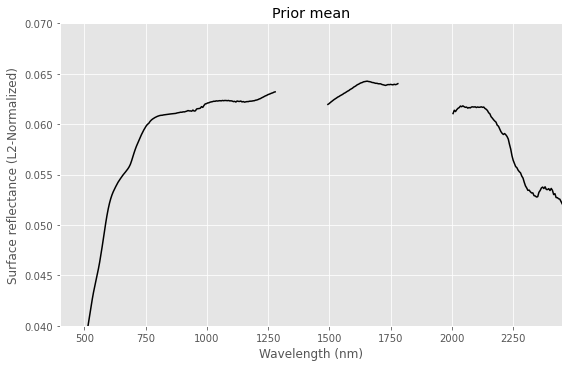

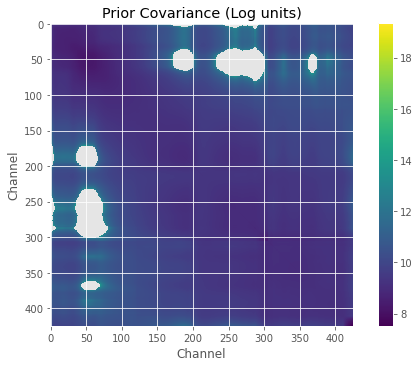

In [3]:
from scipy.io import loadmat, savemat
surf = loadmat(join('data','surface_correlated.mat'))

component  = fm.surface.component(rfl_est, geom)
prior_cov  = surf['covs'][component]
prior_mean = surf['means'][component]
prior_mean[dont_plot] = np.NaN
plt.plot(wavelengths, prior_mean,'k')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance (L2-Normalized)')
plt.title('Prior mean')
plt.xlim([400,2450])
plt.ylim([0.04,0.07]);

plt.figure()
plt.imshow(abs(np.log(prior_cov)));
plt.title('Prior Covariance (Log units)')
plt.xlabel('Channel')
plt.ylabel('Channel');
plt.colorbar();
plt.savefig('prior_covariance.pdf')

These reflectances are designed to capture only the weakest constraints on plausible surface reflectance, to avoid biasing retrievals.  We accomplish these loose constraints with an artificially "broad" covariance structure.  Tightening this covariance, and regenerating all the models, produces a biased retrieval that looks too much like the prior. 

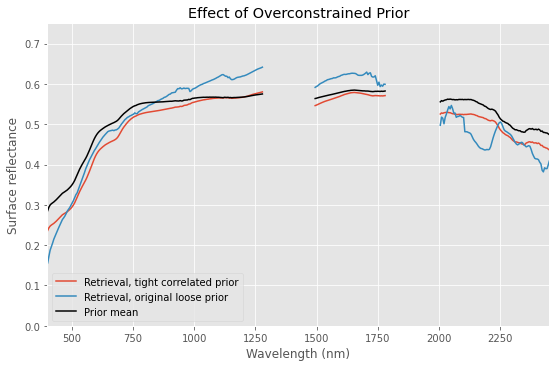

In [4]:
# Load the surface model, tighten the covariance, and save it back
surf = loadmat(join('data','surface_correlated.mat'))
surf['covs'] = [C *0.0001 for C in surf['covs']]
savemat('my_surface.mat', surf)

# Rebuild the forward model and inversion
surface_settings["surface_file"]="my_surface.mat"
fm_config = Config({ "forward_model":{"instrument":instrument_settings,
                   "surface":surface_settings,
                   "radiative_transfer": rtm_settings}})
fm = ForwardModel(fm_config)
iv = Inversion(inverse_config, fm)

# Perform the inversion 
state_trajectory = iv.invert(radiance, geom)
state_est = state_trajectory[-1]

# Plot the new result
rfl_est_tight = state_est[:-2]
rfl_est_tight[dont_plot] = np.NaN
plt.plot(wavelengths, rfl_est_tight)

# Plot the original
rfl_est_original = rfl_est.copy()
rfl_est_original[dont_plot] = np.NaN
plt.plot(wavelengths, rfl_est_original)

# The mean prior is stored as an L2-normalized vector, with the
# norm calculated over some reference wavelengths. To plot it 
# on a similar scale, we rescale by the magnitude of our actual
# reflectance spectrum
scaling = norm(rfl_est[fm.surface.idx_ref])
prior_mean = surf['means'][component] * scaling
prior_mean[dont_plot] = np.NaN
plt.plot(wavelengths, prior_mean,'k')

# Annotations
plt.title('Effect of Overconstrained Prior')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.legend(['Retrieval, tight correlated prior',
            'Retrieval, original loose prior','Prior mean']);
plt.xlim([400,2450])
plt.ylim([0,0.75]);
plt.savefig('overconstrained_prior.pdf')

On the other hand, the alternative - a very weak covariance structure with only loose diagonal elements - is great for resolving sharp mineral features, but leaves nasty residuals in the near infrared water vapor bands near 940 and 1140 nm.

/Users/drt/src/anaconda37/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


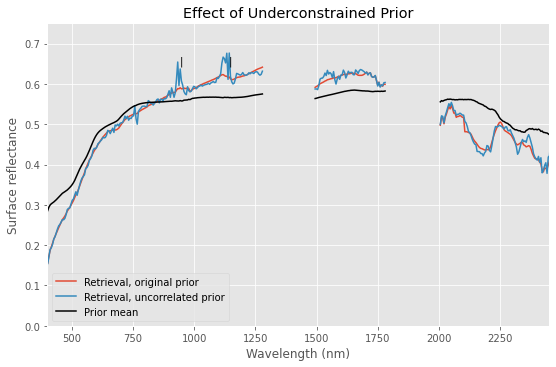

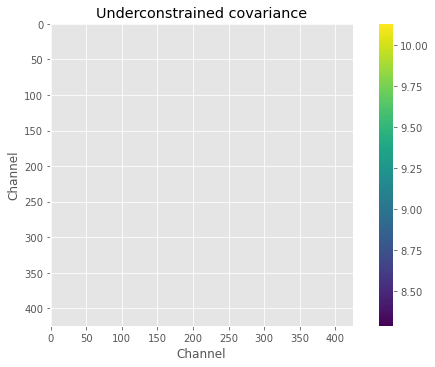

In [5]:
# Load the surface model, tighten the covariance, and save it back
surf = loadmat(join('data','surface_correlated.mat'))
surf['covs'] = [np.zeros(C.shape) + np.eye(C.shape[0])*1e-4 for C in surf['covs']]
savemat('my_surface.mat', surf)

# Rebuild the forward model and inversion
fm_config = Config({ "forward_model":{"instrument":instrument_settings,
                   "surface":surface_settings,
                   "radiative_transfer": rtm_settings}})
fm = ForwardModel(fm_config)
iv = Inversion(inverse_config, fm)

# Perform the inversion and plot the result.
state_trajectory = iv.invert(radiance, geom)
state_est = state_trajectory[-1]
rfl_est_diag = state_est[:-2]
rfl_est_diag[dont_plot] = np.NaN
plt.plot(wavelengths, rfl_original)
plt.plot(wavelengths, rfl_est_diag)

# The mean prior is stored as an L2-normalized vector, with the
# norm calculated over some reference wavelengths. To plot it 
# on a similar scale, we rescale by the magnitude of our actual
# reflectance spectrum
scaling = norm(rfl_est[fm.surface.idx_ref])
plt.plot(wavelengths, prior_mean,'k')
plt.title('Effect of Underconstrained Prior')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.legend(['Retrieval, original prior',
            'Retrieval, uncorrelated prior','Prior mean']);
plt.xlim([400,2450])
plt.ylim([0,0.75]);
plt.savefig('underconstrained_prior.pdf')
plt.text(940, 0.65,"|")
plt.text(1140, 0.65,"|");

# Now show the covariance
plt.figure()
plt.imshow(abs(np.log(surf['covs'][component])));
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.colorbar()
plt.title('Underconstrained covariance');
plt.savefig('underconstrained_prior_covariance.pdf')

Maybe we can compromise.  Let's create a block diagonal covariance structure that preserves some degree of covariance near the 940 water vapor feature, but leaves the rest of the channels uncorrelated. This successfully irons out one of the two water vapor features.

/Users/drt/src/anaconda37/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


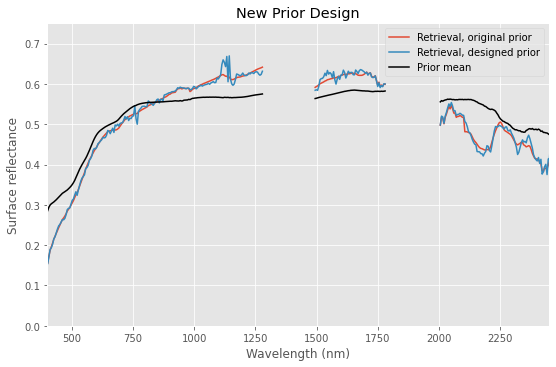

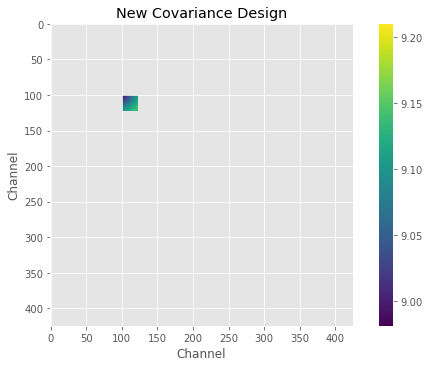

In [7]:
# Load the surface model
surf = loadmat(join('data','surface_correlated.mat'))
new_covs = []

# We will only preserve the correlations in the water vapor absorption at 940, 
# and leave everything else loose and uncorrelated
lo_idx = np.argmin(abs(wavelengths-880))
hi_idx = np.argmin(abs(wavelengths-1000))

for ci, C_orig in enumerate(surf['covs']):
    
    # Construct the new covariance from scratch
    C = np.eye(len(wavelengths)) * 1e-4
    
    # Water vapor feature
    C[lo_idx:hi_idx,lo_idx:hi_idx] = C_orig[lo_idx:hi_idx,lo_idx:hi_idx]
    
    new_covs.append(C)

# Now put the covariances back in the dictionary and save the object to file
for ci in range(len(surf['covs'])):
    surf['covs'][ci] = new_covs[ci]
savemat('my_surface.mat', surf)

# Rebuild the forward model, reloading the surface file. 
# Reconstruct the inversion object
fm_config = Config({ "forward_model":{"instrument":instrument_settings,
                   "surface":surface_settings,
                   "radiative_transfer": rtm_settings}})
fm = ForwardModel(fm_config)
iv = Inversion(inverse_config, fm)

# Perform the inversion and plot the result.
state_trajectory = iv.invert(radiance, geom)
state_est = state_trajectory[-1]
rfl_est_new = state_est[:-2]
rfl_est_new[dont_plot] = np.NaN

plt.plot(wavelengths, rfl_est_original)
plt.plot(wavelengths, rfl_est_new)
plt.plot(wavelengths, prior_mean,'k')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.legend(['Retrieval, original prior',
            'Retrieval, designed prior','Prior mean']);
plt.title('New Prior Design')
plt.xlim([400,2450])
plt.ylim([0,0.75]);
plt.savefig('designed_prior.pdf')

# Now show the covariance
plt.figure()
plt.imshow(abs(np.log(surf['covs'][component])));
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.colorbar()
plt.title('New Covariance Design');
plt.savefig('designed_prior_covariance.pdf')


<b>Question:</b> Can you also erase the water vapor feature at 1140 nm by extending this approach?

<b>Question:</b> Are there advantages to respecting cross-correlations between the two features?  Perhaps the averaging kernel matrix $A$ would help us answer this question.

<b>Question:</b> What other covariance structures are possible?  How could we fit the original dense covariance structures to our advantage?

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.